## 1. import data and libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults 

In [2]:
dr = pd.read_csv('Electric_Production.csv')

In [3]:
df = dr
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    397 non-null    object 
 1   Value   397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


## 2. EDA ##

In [4]:
# Change DATE type from Object to datetime #
df["DATE"] = pd.to_datetime(df["DATE"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    397 non-null    datetime64[ns]
 1   Value   397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [5]:
df.head(5)

,DATE,Value
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


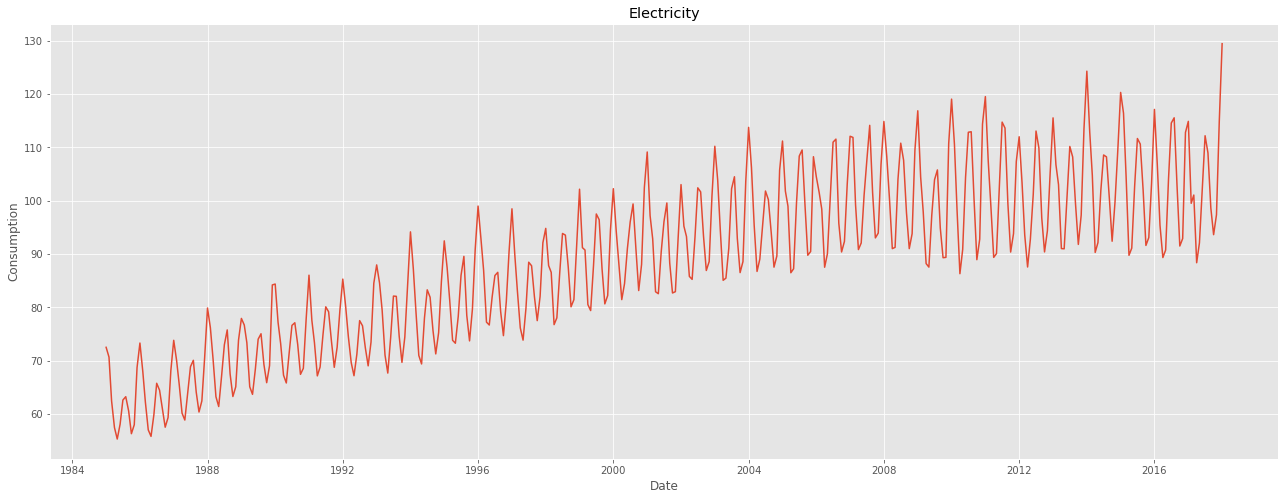

In [6]:
## View Data

plt.figure(figsize=(22,8))
plt.plot(df.DATE, df.Value)
plt.title("Electricity")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.show()

 - 그래프상 트렌드(우상향), 계절성(아마 12일듯), 분산이 커짐이 보임 -> 비정상성 보임

<Figure size 432x288 with 0 Axes>

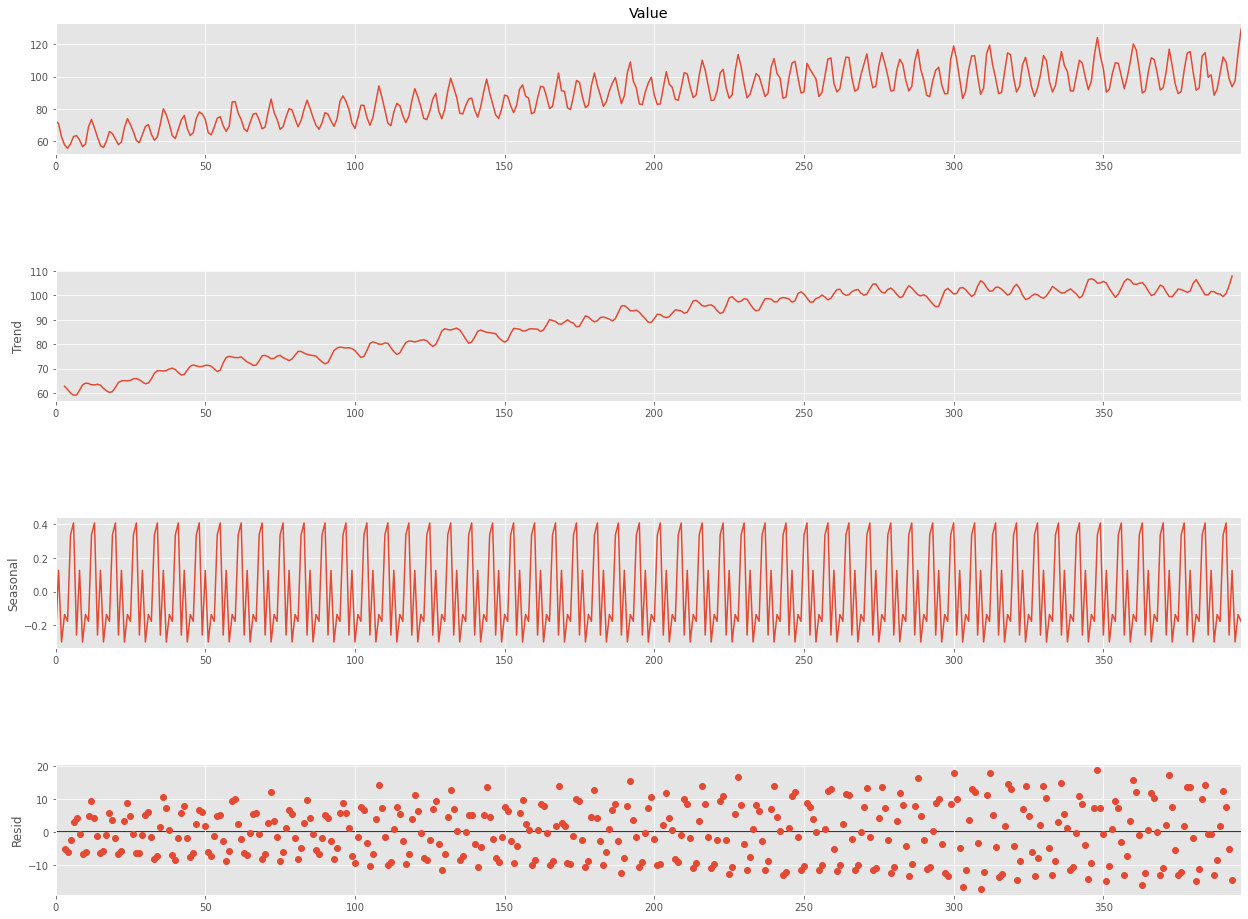

In [7]:
result = seasonal_decompose(df['Value'], model = 'additive', freq = 7) #freq 값 설정

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

## 3. Choose p,d,q of ARIMA ##

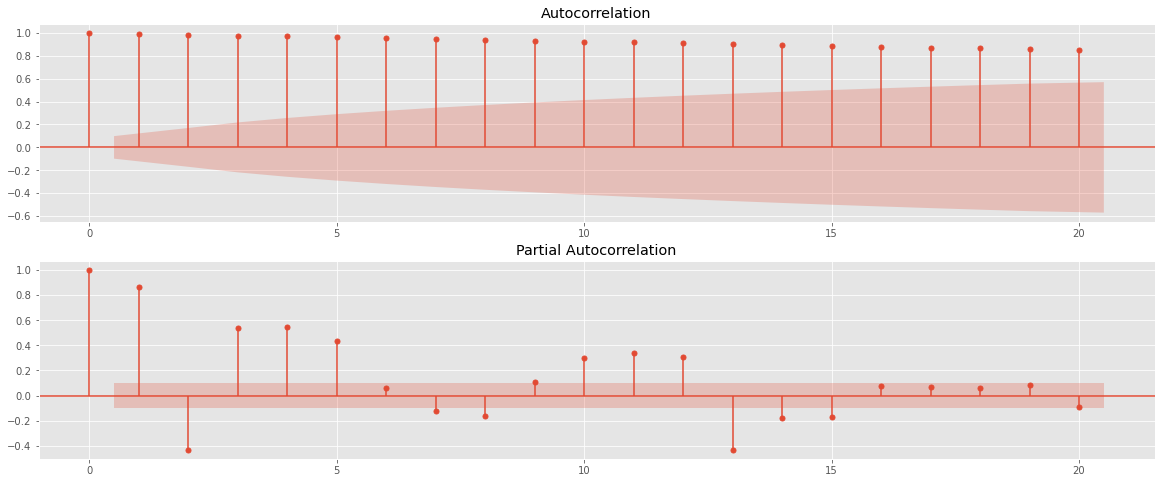

In [8]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

fig = sm.graphics.tsa.plot_acf(df['DATE'], lags=20, ax = ax1)
fig = sm.graphics.tsa.plot_pacf(df['Value'], lags=20, ax = ax2)

In [9]:
## ADFuller Test #
result = adfuller(df['Value'])
print('ADF Stat : %f'  % result[0])
print('P-value : %f'  % result[1])
print('Critical Values :')
for key,value in result[4].items() :
    print('\t%s : %.3f' % (key, value))
## As P-value is bigger than .05, cannot reject H0, which means data does not satisfies stationarity

ADF Stat : -2.256990
P-value : 0.186215
Critical Values :
	1% : -3.448
	5% : -2.869
	10% : -2.571


 - ACF, PACF 모두 불안정하고 ADFuller test도 p-value 0.05 이상이므로 차분 필요

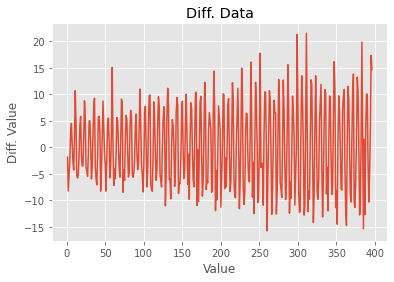

In [10]:
# 1차 차분 #
ts = df['Value']
ts_diff = ts - ts.shift()
plt.plot(ts_diff)
plt.title("Diff. Data")
plt.xlabel("Value")
plt.ylabel("Diff. Value")
plt.show()

In [11]:
# 1차차분 데이터 adfuller test #
result = adfuller(ts_diff[1:])
print('ADF Stat : %f'  % result[0])
print('P-value : %f'  % result[1])
print('Critical Values :')
for key,value in result[4].items() :
    print('\t%s : %.3f' % (key, value))

ADF Stat : -7.104891
P-value : 0.000000
Critical Values :
	1% : -3.448
	5% : -2.869
	10% : -2.571


 - 그래프도 random하며 adfuller test도 통과하므로 d = 1

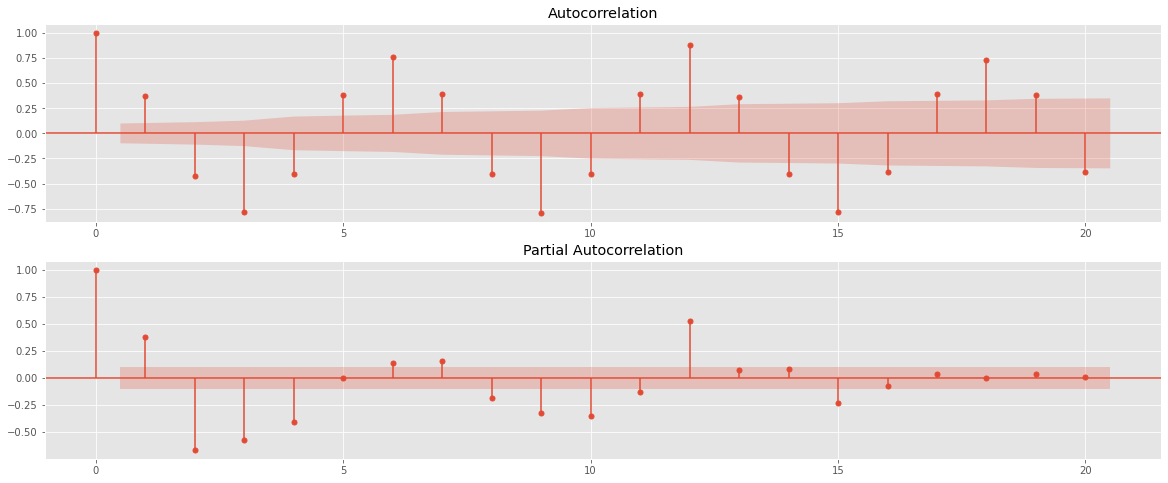

In [12]:
## p,q 정하기 ##
fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff[1:], lags = 20, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff[1:], lags = 20, ax = ax2)

 - p,q가 불안정하여 데이터 로그 변환 후 1차 차분 실시

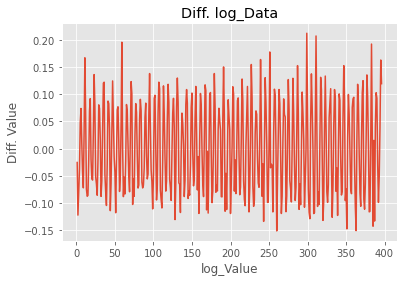

In [13]:
# 원데이터 로그 변환 후 1차 차분 #
df["log_Value"] = np.log1p(df["Value"])
ts = df['log_Value']
ts_diff = ts - ts.shift()
plt.plot(ts_diff)
plt.title("Diff. log_Data")
plt.xlabel("log_Value")
plt.ylabel("Diff. Value")
plt.show()

In [14]:
# ADFuller Test #
result = adfuller(ts_diff[1:])
print('ADF Stat : %f'  % result[0])
print('P-value : %f'  % result[1])
print('Critical Values :')
for key,value in result[4].items() :
    print('\t%s : %.3f' % (key, value))

ADF Stat : -6.754013
P-value : 0.000000
Critical Values :
	1% : -3.448
	5% : -2.869
	10% : -2.571


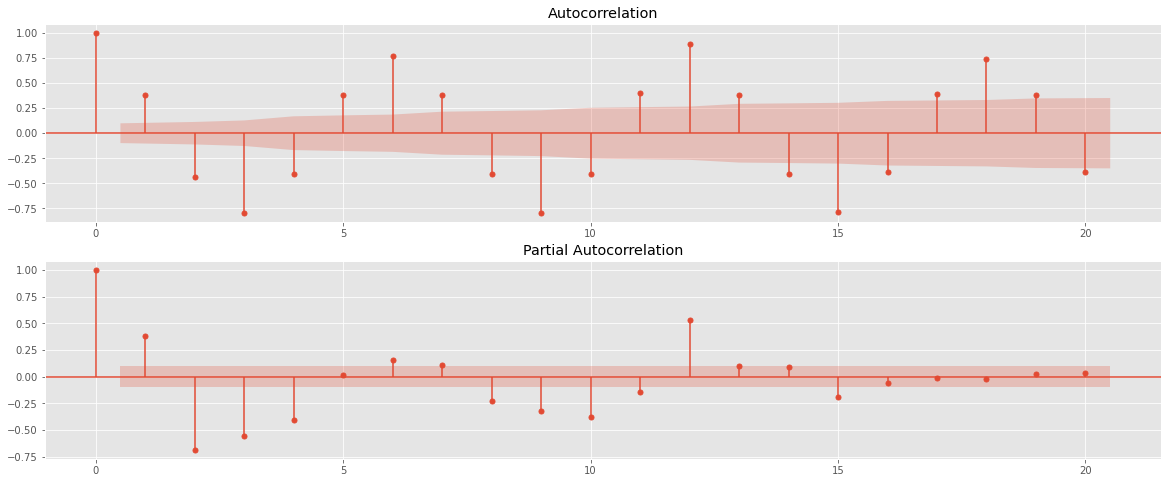

In [15]:
## p,q 정하기 ##
fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff[1:], lags = 20, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff[1:], lags = 20, ax = ax2)

 - log를 취해도 p,q가 안정화되지 않아 원데이터 2차 차분까지 해보기

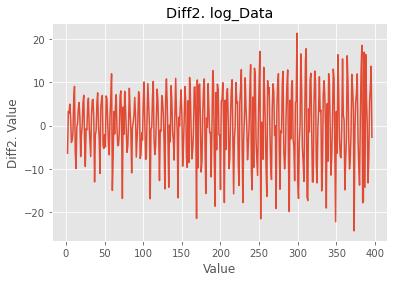

In [16]:
# 2차 차분
ts = df['Value']
ts_diff = ts - ts.shift()
ts_diff2 = ts_diff - ts_diff.shift()
plt.plot(ts_diff2)
plt.title("Diff2. log_Data")
plt.xlabel("Value")
plt.ylabel("Diff2. Value")
plt.show()

In [17]:
# ADFuller Test #
result = adfuller(ts_diff2[2:])
print('ADF Stat : %f'  % result[0])
print('P-value : %f'  % result[1])
print('Critical Values :')
for key,value in result[4].items() :
    print('\t%s : %.3f' % (key, value))

ADF Stat : -9.863042
P-value : 0.000000
Critical Values :
	1% : -3.448
	5% : -2.869
	10% : -2.571


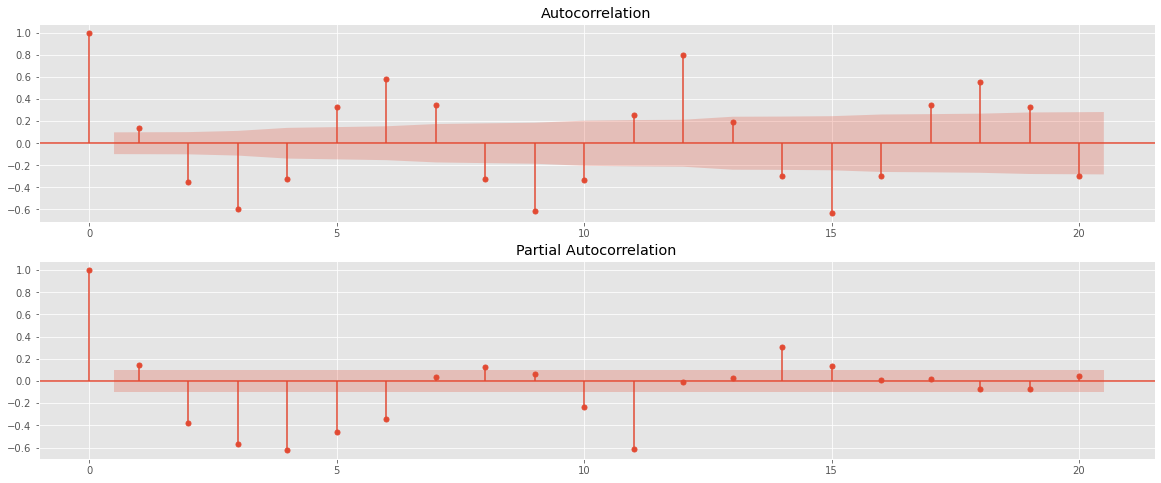

In [18]:
## p,q 정하기 ##
fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff2[2:], lags = 20, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff2[2:], lags = 20, ax = ax2)

 - 2차까지 했는데도 arima 불가. SARIMA 전환

## 4. SARIMA

In [19]:
# 시계열 관련 statsmodels 패키지
from statsmodels.tsa.api import *
from statsmodels.tsa.ar_model import *
from statsmodels.tsa.arima.model import *
from statsmodels.tsa.arima_process import *
from statsmodels.tsa.statespace import *
from statsmodels.graphics.api import *
from statsmodels.graphics.tsaplots import *
#

In [20]:
# seasonal period 설정
import itertools
season = 12
data = df['Value']

# 최적 파라미터 탐색 : SARIMA
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [ ( x[0], x[1], x[2], season ) for x in list(itertools.product(p, d, q)) ] # 1개월 단위의 계절변동을 보이므로 12 입력

aic = []
params = []

for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX( data, order = (i), seasonal_order = (j) )
            fit_model = model.fit()
            print( f'SARIMA: {i}{j} >> AIC : {round(fit_model.aic, 2)}' )
            aic.append( round(fit_model.aic, 2) )
            params.append( (i, j) )
        except:
            continue
print()


# AIC 작은 순서대로 정렬하여 상위 3개 추출
aic_copy = aic.copy()
aic_copy.sort()

optimal_1 = [ (params[i], j) for i, j in enumerate(aic) if j == aic_copy[0] ]
optimal_2 = [ (params[i], j) for i, j in enumerate(aic) if j == aic_copy[1] ]
optimal_3 = [ (params[i], j) for i, j in enumerate(aic) if j == aic_copy[2] ]

print( '< 1st optimal >',
      '\npdq =', optimal_1[0][0][0],
      '\nseasonal_pdq =', optimal_1[0][0][1],
      '\nminimum AIC =', optimal_1[0][1] )
print()
print( '< 2nd optimal >',
      '\npdq =', optimal_2[0][0][0],
      '\nseasonal_pdq =', optimal_2[0][0][1],
      '\nminimum AIC =', optimal_2[0][1] )
print()
print( '< 3rd optimal >',
      '\npdq =', optimal_3[0][0][0],
      '\nseasonal_pdq =', optimal_3[0][0][1],
      '\nminimum AIC =', optimal_3[0][1] )

SARIMA: (0, 1, 0)(0, 1, 0, 12) >> AIC : 2010.16
SARIMA: (0, 1, 0)(0, 1, 1, 12) >> AIC : 1862.15
SARIMA: (0, 1, 0)(0, 1, 2, 12) >> AIC : 1863.43
SARIMA: (0, 1, 0)(1, 1, 0, 12) >> AIC : 1953.95
SARIMA: (0, 1, 0)(1, 1, 1, 12) >> AIC : 1863.71
SARIMA: (0, 1, 0)(1, 1, 2, 12) >> AIC : 1862.19
SARIMA: (0, 1, 0)(2, 1, 0, 12) >> AIC : 1897.76
SARIMA: (0, 1, 0)(2, 1, 1, 12) >> AIC : 1853.61
SARIMA: (0, 1, 0)(2, 1, 2, 12) >> AIC : 1852.61
SARIMA: (0, 1, 1)(0, 1, 0, 12) >> AIC : 1972.42
SARIMA: (0, 1, 1)(0, 1, 1, 12) >> AIC : 1835.3
SARIMA: (0, 1, 1)(0, 1, 2, 12) >> AIC : 1835.97
SARIMA: (0, 1, 1)(1, 1, 0, 12) >> AIC : 1923.36
SARIMA: (0, 1, 1)(1, 1, 1, 12) >> AIC : 1836.55
SARIMA: (0, 1, 1)(1, 1, 2, 12) >> AIC : 1835.17
SARIMA: (0, 1, 1)(2, 1, 0, 12) >> AIC : 1872.59
SARIMA: (0, 1, 1)(2, 1, 1, 12) >> AIC : 1823.21
SARIMA: (0, 1, 1)(2, 1, 2, 12) >> AIC : 1814.63
SARIMA: (0, 1, 2)(0, 1, 0, 12) >> AIC : 1929.68
SARIMA: (0, 1, 2)(0, 1, 1, 12) >> AIC : 1792.17
SARIMA: (0, 1, 2)(0, 1, 2, 12) >> AIC : 1

In [21]:
## 모델 생성 및 적합 ##
model = SARIMAX( data,
                 order = (1, 1, 1),
                 seasonal_order = (2, 1, 2, 12) )

fit_model = model.fit()

print( fit_model.summary() )

                                        SARIMAX Results                                        
Dep. Variable:                                   Value   No. Observations:                  397
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                -878.335
Date:                                 Sat, 27 Nov 2021   AIC                           1770.670
Time:                                         09:05:05   BIC                           1798.324
Sample:                                              0   HQIC                          1781.639
                                                 - 397                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4963      0.047     10.492      0.000       0.404       0

시계열 모델은 아래 테스트 p값이 모두 0.05 이상이어야 함 
 - Ljung-Box test  
    H0 : Residuals are white noise
 - Jarque-Bera test  
    H0 : Residuals are normal distribution
 - Heteroskedaticity  
    H0 : Variance of Residuals are homoscedastic

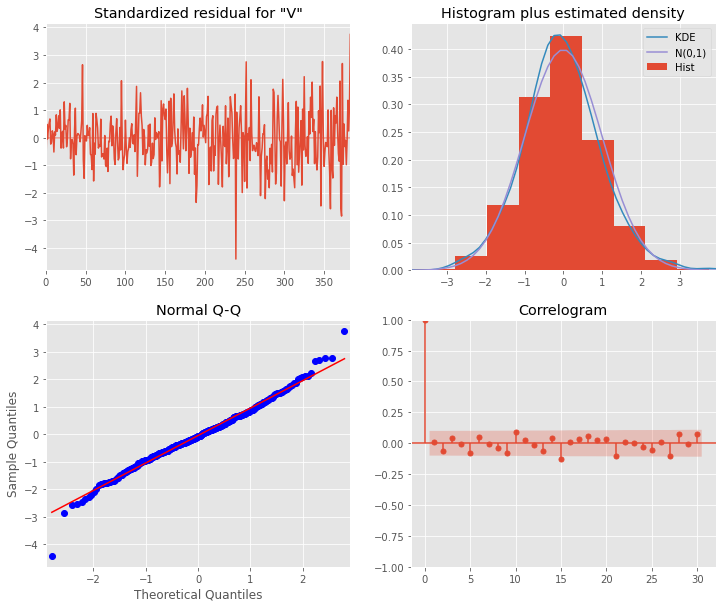

In [22]:
# 잔차분석
fit_model.plot_diagnostics( figsize =(12,10), lags = 30);

 - Jarque-Bera test, Heteroskedaticity test 통과 X
 - 분산이 점점 커지는 관계로 로그 변환 후 sarima

In [23]:
## 데이터 로그 변환 후 sarima params 찾기
season = 12
df['log_Value'] = np.log1p(df['Value'])
data = df['log_Value']

# 최적 파라미터 탐색 : SARIMA
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [ ( x[0], x[1], x[2], season ) for x in list(itertools.product(p, d, q)) ] # 1개월 단위의 계절변동을 보이므로 12 입력

aic = []
params = []

for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX( data, order = (i), seasonal_order = (j) )
            fit_model = model.fit()
            print( f'SARIMA: {i}{j} >> AIC : {round(fit_model.aic, 2)}' )
            aic.append( round(fit_model.aic, 2) )
            params.append( (i, j) )
        except:
            continue
print()


# AIC 작은 순서대로 정렬하여 상위 3개 추출
aic_copy = aic.copy()
aic_copy.sort()

optimal_1 = [ (params[i], j) for i, j in enumerate(aic) if j == aic_copy[0] ]
optimal_2 = [ (params[i], j) for i, j in enumerate(aic) if j == aic_copy[1] ]
optimal_3 = [ (params[i], j) for i, j in enumerate(aic) if j == aic_copy[2] ]

print( '< 1st optimal >',
      '\npdq =', optimal_1[0][0][0],
      '\nseasonal_pdq =', optimal_1[0][0][1],
      '\nminimum AIC =', optimal_1[0][1] )
print()
print( '< 2nd optimal >',
      '\npdq =', optimal_2[0][0][0],
      '\nseasonal_pdq =', optimal_2[0][0][1],
      '\nminimum AIC =', optimal_2[0][1] )
print()
print( '< 3rd optimal >',
      '\npdq =', optimal_3[0][0][0],
      '\nseasonal_pdq =', optimal_3[0][0][1],
      '\nminimum AIC =', optimal_3[0][1] )

SARIMA: (0, 1, 0)(0, 1, 0, 12) >> AIC : -1509.55
SARIMA: (0, 1, 0)(0, 1, 1, 12) >> AIC : -1675.61
SARIMA: (0, 1, 0)(0, 1, 2, 12) >> AIC : -1675.31
SARIMA: (0, 1, 0)(1, 1, 0, 12) >> AIC : -1566.81
SARIMA: (0, 1, 0)(1, 1, 1, 12) >> AIC : -1674.76
SARIMA: (0, 1, 0)(1, 1, 2, 12) >> AIC : -1676.26
SARIMA: (0, 1, 0)(2, 1, 0, 12) >> AIC : -1623.35
SARIMA: (0, 1, 0)(2, 1, 1, 12) >> AIC : -1681.5


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (0, 1, 0)(2, 1, 2, 12) >> AIC : -1679.6
SARIMA: (0, 1, 1)(0, 1, 0, 12) >> AIC : -1547.85
SARIMA: (0, 1, 1)(0, 1, 1, 12) >> AIC : -1706.9
SARIMA: (0, 1, 1)(0, 1, 2, 12) >> AIC : -1706.65
SARIMA: (0, 1, 1)(1, 1, 0, 12) >> AIC : -1600.59
SARIMA: (0, 1, 1)(1, 1, 1, 12) >> AIC : -1706.01
SARIMA: (0, 1, 1)(1, 1, 2, 12) >> AIC : -1707.11
SARIMA: (0, 1, 1)(2, 1, 0, 12) >> AIC : -1651.19


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (0, 1, 1)(2, 1, 1, 12) >> AIC : -1715.83


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (0, 1, 1)(2, 1, 2, 12) >> AIC : -1716.95
SARIMA: (0, 1, 2)(0, 1, 0, 12) >> AIC : -1585.2
SARIMA: (0, 1, 2)(0, 1, 1, 12) >> AIC : -1737.51
SARIMA: (0, 1, 2)(0, 1, 2, 12) >> AIC : -1721.68
SARIMA: (0, 1, 2)(1, 1, 0, 12) >> AIC : -1637.23
SARIMA: (0, 1, 2)(1, 1, 1, 12) >> AIC : -1736.57


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (0, 1, 2)(1, 1, 2, 12) >> AIC : -1737.83
SARIMA: (0, 1, 2)(2, 1, 0, 12) >> AIC : -1692.44
SARIMA: (0, 1, 2)(2, 1, 1, 12) >> AIC : -1745.16


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (0, 1, 2)(2, 1, 2, 12) >> AIC : -1740.41
SARIMA: (1, 1, 0)(0, 1, 0, 12) >> AIC : -1525.67
SARIMA: (1, 1, 0)(0, 1, 1, 12) >> AIC : -1691.93
SARIMA: (1, 1, 0)(0, 1, 2, 12) >> AIC : -1691.23


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (1, 1, 0)(1, 1, 0, 12) >> AIC : -1582.21
SARIMA: (1, 1, 0)(1, 1, 1, 12) >> AIC : -1690.78
SARIMA: (1, 1, 0)(1, 1, 2, 12) >> AIC : -1691.63
SARIMA: (1, 1, 0)(2, 1, 0, 12) >> AIC : -1635.8
SARIMA: (1, 1, 0)(2, 1, 1, 12) >> AIC : -1699.27


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (1, 1, 0)(2, 1, 2, 12) >> AIC : -1698.89


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (1, 1, 1)(0, 1, 0, 12) >> AIC : -1595.86


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (1, 1, 1)(0, 1, 1, 12) >> AIC : -1745.34


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (1, 1, 1)(0, 1, 2, 12) >> AIC : -1744.63
SARIMA: (1, 1, 1)(1, 1, 0, 12) >> AIC : -1647.42


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (1, 1, 1)(1, 1, 1, 12) >> AIC : -1744.17


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (1, 1, 1)(1, 1, 2, 12) >> AIC : -1745.53


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (1, 1, 1)(2, 1, 0, 12) >> AIC : -1700.78


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (1, 1, 1)(2, 1, 1, 12) >> AIC : -1751.46


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (1, 1, 1)(2, 1, 2, 12) >> AIC : -1750.39
SARIMA: (1, 1, 2)(0, 1, 0, 12) >> AIC : -1594.16


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (1, 1, 2)(0, 1, 1, 12) >> AIC : -1743.67
SARIMA: (1, 1, 2)(0, 1, 2, 12) >> AIC : -1730.87


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (1, 1, 2)(1, 1, 0, 12) >> AIC : -1645.75


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (1, 1, 2)(1, 1, 1, 12) >> AIC : -1730.55


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (1, 1, 2)(1, 1, 2, 12) >> AIC : -1743.82
SARIMA: (1, 1, 2)(2, 1, 0, 12) >> AIC : -1657.94


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (1, 1, 2)(2, 1, 1, 12) >> AIC : -1737.27


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (1, 1, 2)(2, 1, 2, 12) >> AIC : -1745.32
SARIMA: (2, 1, 0)(0, 1, 0, 12) >> AIC : -1562.58


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 0)(0, 1, 1, 12) >> AIC : -1711.8
SARIMA: (2, 1, 0)(0, 1, 2, 12) >> AIC : -1712.74


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 0)(1, 1, 0, 12) >> AIC : -1614.04
SARIMA: (2, 1, 0)(1, 1, 1, 12) >> AIC : -1711.78


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 0)(1, 1, 2, 12) >> AIC : -1712.83
SARIMA: (2, 1, 0)(2, 1, 0, 12) >> AIC : -1663.0


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 0)(2, 1, 1, 12) >> AIC : -1719.07


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 0)(2, 1, 2, 12) >> AIC : -1716.19
SARIMA: (2, 1, 1)(0, 1, 0, 12) >> AIC : -1593.98


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 1)(0, 1, 1, 12) >> AIC : -1743.64


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 1)(0, 1, 2, 12) >> AIC : -1736.26
SARIMA: (2, 1, 1)(1, 1, 0, 12) >> AIC : -1645.58


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 1)(1, 1, 1, 12) >> AIC : -1742.44


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 1)(1, 1, 2, 12) >> AIC : -1740.81


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 1)(2, 1, 0, 12) >> AIC : -1698.53


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 1)(2, 1, 1, 12) >> AIC : -1727.85


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 1)(2, 1, 2, 12) >> AIC : -1740.9
SARIMA: (2, 1, 2)(0, 1, 0, 12) >> AIC : -1571.08


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 2)(0, 1, 1, 12) >> AIC : -1742.1


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 2)(0, 1, 2, 12) >> AIC : -1742.38
SARIMA: (2, 1, 2)(1, 1, 0, 12) >> AIC : -1648.71


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 2)(1, 1, 1, 12) >> AIC : -1741.18


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 2)(1, 1, 2, 12) >> AIC : -1742.33


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 2)(2, 1, 0, 12) >> AIC : -1700.84


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 2)(2, 1, 1, 12) >> AIC : -1748.11


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA: (2, 1, 2)(2, 1, 2, 12) >> AIC : -1742.97

< 1st optimal > 
pdq = (1, 1, 1) 
seasonal_pdq = (2, 1, 1, 12) 
minimum AIC = -1751.46

< 2nd optimal > 
pdq = (1, 1, 1) 
seasonal_pdq = (2, 1, 2, 12) 
minimum AIC = -1750.39

< 3rd optimal > 
pdq = (2, 1, 2) 
seasonal_pdq = (2, 1, 1, 12) 
minimum AIC = -1748.11


In [24]:
## 모델 생성 및 적합 ##
model = SARIMAX( data,
                 order = (1, 1, 1),
                 seasonal_order = (2, 1, 2, 12) )

fit_model = model.fit()

print( fit_model.summary() )

C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                        SARIMAX Results                                        
Dep. Variable:                               log_Value   No. Observations:                  397
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                 882.195
Date:                                 Sat, 27 Nov 2021   AIC                          -1750.390
Time:                                         09:10:54   BIC                          -1722.735
Sample:                                              0   HQIC                         -1739.421
                                                 - 397                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5212      0.057      9.204      0.000       0.410       0

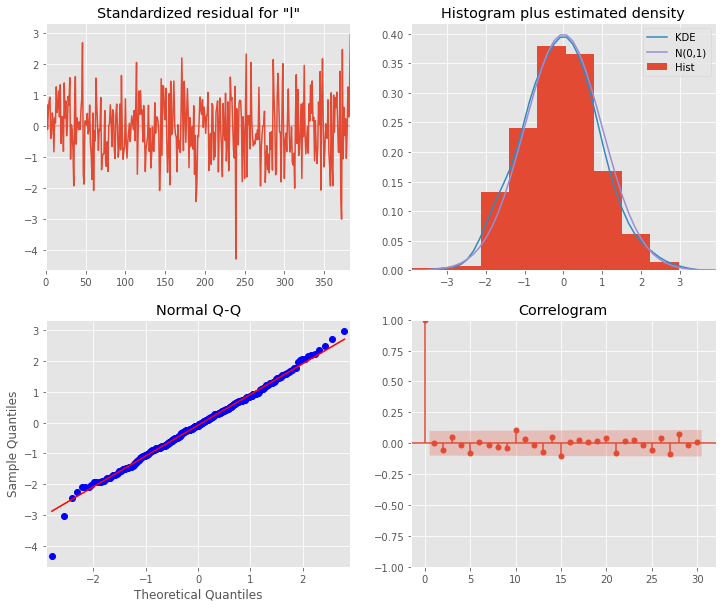

In [25]:
# 잔차분석
fit_model.plot_diagnostics( figsize =(12,10), lags = 30);

 - 여전히 Heteroskedasticity 통과 X 

In [26]:
## Fit Model to data
res = sm.tsa.statespace.SARIMAX(data,
                                order = (1, 1, 1),
                                seasonal_order = (2, 1, 2, 12),
                                enforce_stationarity = True,
                               enforce_invertibility = True).fit()

## In-sample prediction and confidence bounds
pred = res.get_prediction(start = 385,
                          end = 396,
                          dynamic = True)


C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



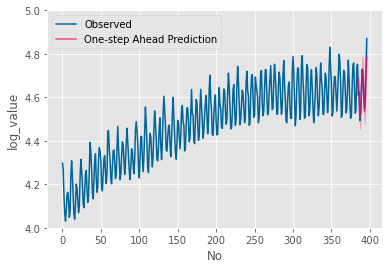

In [27]:
pred_ci = pred.conf_int()

## Plot in-sample prediction
ax = data[0:].plot(label = 'Observed', color = '#006699')
pred.predicted_mean.plot(ax=ax, label = 'One-step Ahead Prediction', alpha=.7, color = '#ff0066');

## Draw confidence bound (gray)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color = '#ff0066', alpha=.25);

## Style the plot
ax.fill_between(ax.get_ylim(), 385, data.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('No')
ax.set_ylabel('log_value')
plt.ylim(4,5)
plt.legend(loc='upper left')
plt.show()

In [26]:
df

,DATE,Value,log_Value
0,1985-01-01,72.5052,4.297356
1,1985-02-01,70.6720,4.272100
2,1985-03-01,62.4502,4.150255
3,1985-04-01,57.4714,4.068538
4,1985-05-01,55.3151,4.030963
...,...,...,...
392,2017-09-01,98.6154,4.601317
393,2017-10-01,93.6137,4.549802
394,2017-11-01,97.3359,4.588389
395,2017-12-01,114.7212,4.751184
